# **Big Data Challenge**
Kelompok: Andrew, Audrey, Marjuenz

In [ ]:
!pip install Sastrawi
!pip install accelerate -U
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/209.7 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺ 204.8/209.7 kB 7.1 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.wh

In [ ]:
#tentative
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import tensorflow as tf
import csv
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import gensim.downloader as api
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from sklearn.metrics import balanced_accuracy_score

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# **1. Collecting Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/Datasets/satria-data

/content/drive/MyDrive/Datasets/satria-data


In [ ]:
df = pd.read_csv("dataset_penyisihan_bdc_2024.csv", sep=';')

In [ ]:
df.head()

text             label
0  Kunjungan Prabowo ini untuk meresmikan dan men...  Sumber Daya Alam
1  RT Anies dapat tepuk tangan meriah saat jadi R...           Politik
2  @CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= ...         Demografi
3  RT @L3R8XFBw3WGbxRPSj0/0hHZTbqVGX7qtfwRg9zmhK7...           Politik
4  Anies Baswedan Harap ASN termasuk TNI dan Polr...           Politik

In [ ]:
df['text'][2]

'@CIqXqwGAT04tMtx4OCATxjoVq7vv/Y8HeYaIOgMFg8Y= emng bener sih, pendukung 01 ada yg goblok, begitu jg dg pendukung 02.. hnya sj menurut pak Ridwan Kamil skemanya terbalik, klo 01 MAYORITAS PENDIDIKAN MENENGAH ATAS (artinya ada jg pendidikan rendah yg milih'

## a. Data Cleaning

### **UNTUK NON-STEMMING dan STOPWORDS**

#### Menghapus username, hashtag, link, retweet, dan karakter tidak jelas

In [ ]:
def clean_tweet(tweet):
    # Remove hashtags
    tweet = re.sub(r'#\w+', '', tweet)
    # Remove links
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove email
    tweet = re.sub(r'\S*@\S*\s?', '', tweet)
    # Remove mentions and RT, [RE username]
    tweet = re.sub(r'@\w+|RT|(\[RE [^\]]+\])', '', tweet)
    # Remove special characters and numbers
    tweet = re.sub(r'[^A-Za-z\s]', '', tweet)
    # Remove extra spaces
    tweet = re.sub(r'\s+', ' ', tweet).strip()
    return tweet

In [ ]:
# Fungsi untuk membersihkan teks
def clean_tweet(tweet):
    tweet = re.sub(r'@\w+', '', tweet)  # Menghapus mention username
    tweet = re.sub(r'#\w+', '', tweet)  # Menghapus hashtag
    tweet = re.sub(r'http\S+', '', tweet)  # Menghapus link
    tweet = re.sub(r'\bRT\b', '', tweet)  # Menghapus kata "RT"
    tweet = re.sub(r'\breply\b', '', tweet, flags=re.IGNORECASE)  # Menghapus kata "reply"
    tweet = re.sub(r'\bRE\b \S+', '', tweet, flags=re.IGNORECASE)  # Menghapus kata "RE nama_user"
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)  # Menghapus karakter tidak jelas
    tweet = re.sub(r'\b\S*[\+\/=]+\S*\b', '', tweet)  # Menghapus karakter tidak jelas
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet) # Menghapus karakter selain huruf
    tweet = re.sub(r'\s+', ' ', tweet).strip()  # Menghapus spasi ekstra

    words = tweet.split() # Memisahkan teks menjadi daftar kata
    short_words = [word for word in words if len(word) <= 12] # Menghapus kata yang memiliki lebih dari 12 karakter
    tweet = ' '.join(short_words) # Menggabungkan kembali daftar kata menjadi teks

    return tweet

In [ ]:
# Membersihkan kolom tweet
df['c_text1'] = df['text'].apply(clean_tweet)

In [ ]:
# Menampilkan DataFrame hasil pembersihan
df.loc[3300:3320]

text  \
3300  RT TIKTOKERS SELURUH INDONESIA DEKLARASI DUKUN...   
3301  RT @Ce+dbRedk8PStgYnkwQ15TZrYLduMvAMY9Mk8boclM...   
3302  RT Ã¢Â€ÂœBentrok antara warga dengan pendukung...   
3303  VIDEO: PBNU Instruksikan Dukung Pasangan Prabo...   
3304  RT Politics aside, this is how adults should t...   
3305  Bahkan Ganjar bilang kalo dia meragukan Prabow...   
3306  Pasangan Duet Capres Cawapres Ganjar Pranowo d...   
3307  @poQGfTLdT7NdIQmVInhA5vF68KCxHH12+lsxqNbjiHI= ...   
3308  @YVSGcTxAnR8PcOhaG11LddItey18Uq6K+gjjGo5nbDE= ...   
3309  RT Desak Anies Ambon di pinggir pantai Baby In...   
3310  Ã°ÂŸÂ¥Â½ Mas Ganjar Pranowo dan Pak Mahfud MD,...   
3311  @vOd+JNSFcNTT48miXtV+cXjJXsMd8IWuhr1MwHlGykA= ...   
3312  RT Artikel media ternama Israel The Jerusalem ...   
3313  Ganjar Pranowo, membuat solusi cerdas untuk pe...   
3314  @wLDyfLbTC3tzbhn2eku90bL2AqEXLL/f46Fg+VYk3Z4= ...   
3315  Ganjar Pranowo capres yang memahami bahwa hak ...   
3316  RT Pak Ganjar itu orang asyik, ngobrol dengan ...   
3317  Kepemimpinan Prabowo: Teladan dalam memberikan...   
3318  Kenapa si pada panik banget. Kemaren-kemaren k...   
3319  Hajatan Rakyat memberi Ganjar-Mahfud kesempata...   
3320  RT Anies Singgung Panen Singkong di Gorontalo ...   

                        label  \
3300                  Politik   
3301            Sosial Budaya   
3302  Pertahanan dan Keamanan   
3303                  Politik   
3304            Sosial Budaya   
3305                  Politik   
3306                  Politik   
3307                  Ekonomi   
3308            Sosial Budaya   
3309         Sumber Daya Alam   
3310                  Politik   
3311            Sosial Budaya   
3312  Pertahanan dan Keamanan   
3313                  Ekonomi   
3314                 Ideologi   
3315                  Politik   
3316                  Politik   
3317                  Politik   
3318                  Politik   
3319                  Politik   
3320         Sumber Daya Alam   

                                                c_text1  
3300  TIKTOKERS SELURUH INDONESIA DEKLARASI DUKUNG A...  
3301  Yang ngebacot pak Anies Intoleran kebanyakan y...  
3302  Bentrok antara warga dengan pendukung PrabowoG...  
3303  VIDEO PBNU Instruksikan Dukung Pasangan Prabow...  
3304  Politics aside this is how adults should treat...  
3305  Bahkan Ganjar bilang kalo dia meragukan Prabow...  
3306  Pasangan Duet Capres Cawapres Ganjar Pranowo d...  
3307                                                     
3308  Sesuai dan cocok yg disampaikan pak Anies di D...  
3309  Desak Anies Ambon di pinggir pantai Baby Indah...  
3310  Mas Ganjar Pranowo dan Pak Mahfud MD harapan b...  
3311  semoga kesejahteraan petani lebih di perhatika...  
3312  Artikel media ternama Israel The Jerusalem Pos...  
3313  Ganjar Pranowo membuat solusi cerdas untuk per...  
3314  Benar nih MASBowoGBran PASTInya menyampaikan p...  
3315  Ganjar Pranowo capres yang memahami bahwa hak ...  
3316  Pak Ganjar itu orang asyik ngobrol dengan kala...  
3317  Kepemimpinan Prabowo Teladan dalam memberikan ...  
3318  Kenapa si pada panik banget Kemarenkemaren kek...  
3319  Hajatan Rakyat memberi GanjarMahfud kesempatan...  
3320  Anies Singgung Panen Singkong di Gorontalo Ber...

#### Casefolding dan Slangword Replacement

##### slangword

In [ ]:
# Define a dictionary for slang and abbreviation conversion
slang_dict = {
    'emng': 'memang',
    'bener': 'benar',
    'sj': 'saja',
    'yg': 'yang',
    'goblok': 'bodoh',
    'jg': 'juga',
    'dg': 'dengan',
    'klo': 'kalau',
    'kinerja': 'kerja',
    'giliran': 'ganti',
    'skrg': 'sekarang',
    'an': 'dan',
    "@": "di", "abis": "habis", "ad": "ada", "adlh": "adalah", "afaik": "as far as i know", "ahaha": "haha", "aj": "saja", "ajep-ajep": "dunia gemerlap", "ak": "saya", "akika": "aku", "akkoh": "aku", "akuwh": "aku", "alay": "norak", "alow": "halo", "ambilin": "ambilkan", "ancur": "hancur", "anjrit": "anjing", "anter": "antar", "ap2": "apa-apa", "apasih": "apa sih", "apes": "sial", "aps": "apa", "aq": "saya", "aquwh": "aku", "asbun": "asal bunyi", "aseekk": "asyik", "asekk": "asyik", "asem": "asam", "aspal": "asli tetapi palsu", "astul": "asal tulis", "ato": "atau", "au ah": "tidak mau tahu", "awak": "saya", "ay": "sayang", "ayank": "sayang", "b4": "sebelum", "bakalan": "akan", "bandes": "bantuan desa", "bangedh": "banget", "banpol": "bantuan polisi", "banpur": "bantuan tempur", "basbang": "basi", "bcanda": "bercanda", "bdg": "bandung", "begajulan": "nakal", "beliin": "belikan", "bencong": "banci", "bentar": "sebentar", "ber3": "bertiga", "beresin": "membereskan", "bete": "bosan", "beud": "banget", "bg": "abang", "bgmn": "bagaimana", "bgt": "banget", "bijimane": "bagaimana", "bintal": "bimbingan mental", "bkl": "akan", "bknnya": "bukannya", "blegug": "bodoh", "blh": "boleh", "bln": "bulan", "blum": "belum", "bnci": "benci", "bnran": "yang benar", "bodor": "lucu", "bokap": "ayah", "boker": "buang air besar", "bokis": "bohong", "boljug": "boleh juga", "bonek": "bocah nekat", "boyeh": "boleh", "br": "baru", "brg": "bareng", "bro": "saudara laki-laki", "bru": "baru", "bs": "bisa", "bsen": "bosan", "bt": "buat", "btw": "ngomong-ngomong", "buaya": "tidak setia", "bubbu": "tidur", "bubu": "tidur", "bumil": "ibu hamil", "bw": "bawa", "bwt": "buat", "byk": "banyak", "byrin": "bayarkan", "cabal": "sabar", "cadas": "keren", "calo": "makelar", "can": "belum", "capcus": "pergi", "caper": "cari perhatian", "ce": "cewek", "cekal": "cegah tangkal", "cemen": "penakut", "cengengesan": "tertawa", "cepet": "cepat", "cew": "cewek", "chuyunk": "sayang", "cimeng": "ganja", "cipika cipiki": "cium pipi kanan cium pipi kiri", "ciyh": "sih", "ckepp": "cakep", "ckp": "cakep", "cmiiw": "correct me if i'm wrong", "cmpur": "campur", "cong": "banci", "conlok": "cinta lokasi", "cowwyy": "maaf", "cp": "siapa", "cpe": "capek", "cppe": "capek", "cucok": "cocok", "cuex": "cuek", "cumi": "Cuma miscall", "cups": "culun", "curanmor": "pencurian kendaraan bermotor", "curcol": "curahan hati colongan", "cwek": "cewek", "cyin": "cinta", "d": "di", "dah": "deh", "dapet": "dapat", "de": "adik", "dek": "adik", "demen": "suka", "deyh": "deh", "dgn": "dengan", "diancurin": "dihancurkan", "dimaafin": "dimaafkan", "dimintak": "diminta", "disono": "di sana", "dket": "dekat", "dkk": "dan kawan-kawan", "dll": "dan lain-lain", "dlu": "dulu", "dngn": "dengan", "dodol": "bodoh", "doku": "uang", "dongs": "dong", "dpt": "dapat", "dri": "dari", "drmn": "darimana", "drtd": "dari tadi", "dst": "dan seterusnya", "dtg": "datang", "duh": "aduh", "duren": "durian", "ed": "edisi", "egp": "emang gue pikirin", "eke": "aku", "elu": "kamu", "emangnya": "memangnya", "emng": "memang", "endak": "tidak", "enggak": "tidak", "envy": "iri", "ex": "mantan", "fax": "facsimile", "fifo": "first in first out", "folbek": "follow back", "fyi": "sebagai informasi", "gaada": "tidak ada uang", "gag": "tidak", "gaje": "tidak jelas", "gak papa": "tidak apa-apa", "gan": "juragan", "gaptek": "gagap teknologi", "gatek": "gagap teknologi", "gawe": "kerja", "gbs": "tidak bisa", "gebetan": "orang yang disuka", "geje": "tidak jelas", "gepeng": "gelandangan dan pengemis", "ghiy": "lagi", "gile": "gila", "gimana": "bagaimana", "gino": "gigi nongol", "githu": "gitu", "gj": "tidak jelas", "gmana": "bagaimana", "gn": "begini", "goblok": "bodoh", "golput": "golongan putih", "gowes": "mengayuh sepeda", "gpny": "tidak punya", "gr": "gede rasa", "gretongan": "gratisan", "gtau": "tidak tahu", "gua": "saya", "guoblok": "goblok", "gw": "saya", "ha": "tertawa", "haha": "tertawa", "hallow": "halo", "hankam": "pertahanan dan keamanan", "hehe": "he", "helo": "halo", "hey": "hai", "hlm": "halaman", "hny": "hanya", "hoax": "isu bohong", "hr": "hari", "hrus": "harus", "hubdar": "perhubungan darat", "huff": "mengeluh", "hum": "rumah", "humz": "rumah", "ilang": "hilang", "ilfil": "tidak suka", "imho": "in my humble opinion", "imoetz": "imut", "item": "hitam", "itungan": "hitungan", "iye": "iya", "ja": "saja", "jadiin": "jadi", "jaim": "jaga image", "jayus": "tidak lucu", "jdi": "jadi", "jem": "jam", "jga": "juga", "jgnkan": "jangankan", "jir": "anjing", "jln": "jalan", "jomblo": "tidak punya pacar", "jubir": "juru bicara", "jutek": "galak", "k": "ke", "kab": "kabupaten", "kabor": "kabur", "kacrut": "kacau", "kadiv": "kepala divisi", "kagak": "tidak", "kalo": "kalau", "kampret": "sialan", "kamtibmas": "keamanan dan ketertiban masyarakat", "kamuwh": "kamu", "kanwil": "kantor wilayah", "karna": "karena", "kasubbag": "kepala subbagian", "katrok": "kampungan", "kayanya": "kayaknya", "kbr": "kabar", "kdu": "harus", "kec": "kecamatan", "kejurnas": "kejuaraan nasional", "kekeuh": "keras kepala", "kel": "kelurahan", "kemaren": "kemarin", "kepengen": "mau", "kepingin": "mau", "kepsek": "kepala sekolah", "kesbang": "kesatuan bangsa", "kesra": "kesejahteraan rakyat", "ketrima": "diterima", "kgiatan": "kegiatan", "kibul": "bohong", "kimpoi": "kawin", "kl": "kalau", "klianz": "kalian", "kloter": "kelompok terbang", "klw": "kalau", "km": "kamu", "kmps": "kampus", "kmrn": "kemarin", "knal": "kenal", "knp": "kenapa", "kodya": "kota madya", "komdis": "komisi disiplin", "komsov": "komunis sovyet", "kongkow": "kumpul bareng teman-teman", "kopdar": "kopi darat", "korup": "korupsi", "kpn": "kapan", "krenz": "keren", "krm": "kirim", "kt": "kita", "ktmu": "ketemu", "ktr": "kantor", "kuper": "kurang pergaulan", "kw": "imitasi", "kyk": "seperti", "la": "lah", "lam": "salam", "lamp": "lampiran", "lanud": "landasan udara", "latgab": "latihan gabungan", "lebay": "berlebihan", "leh": "boleh", "lelet": "lambat", "lemot": "lambat", "lgi": "lagi", "lgsg": "langsung", "liat": "lihat", "litbang": "penelitian dan pengembangan", "lmyn": "lumayan", "lo": "kamu", "loe": "kamu", "lola": "lambat berfikir", "louph": "cinta", "low": "kalau", "lp": "lupa", "luber": "langsung, umum, bebas, dan rahasia", "luchuw": "lucu", "lum": "belum", "luthu": "lucu", "lwn": "lawan", "maacih": "terima kasih", "mabal": "bolos", "macem": "macam", "macih": "masih", "maem": "makan", "magabut": "makan gaji buta", "maho": "homo", "mak jang": "kaget", "maksain": "memaksa", "malem": "malam", "mam": "makan", "maneh": "kamu", "maniez": "manis", "mao": "mau", "masukin": "masukkan", "melu": "ikut", "mepet": "dekat sekali", "mgu": "minggu", "migas": "minyak dan gas bumi", "mikol": "minuman beralkohol", "miras": "minuman keras", "mlah": "malah", "mngkn": "mungkin", "mo": "mau", "mokad": "mati", "moso": "masa", "mpe": "sampai", "msk": "masuk", "mslh": "masalah", "mt": "makan teman", "mubes": "musyawarah besar", "mulu": "melulu", "mumpung": "selagi", "munas": "musyawarah nasional", "muntaber": "muntah dan berak", "musti": "mesti", "muupz": "maaf", "mw": "now watching", "n": "dan", "nanam": "menanam", "nanya": "bertanya", "napa": "kenapa", "napi": "narapidana", "napza": "narkotika, alkohol, psikotropika, dan zat adiktif ", "narkoba": "narkotika, psikotropika, dan obat terlarang", "nasgor": "nasi goreng", "nda": "tidak", "ndiri": "sendiri", "ne": "ini", "nekolin": "neokolonialisme", "nembak": "menyatakan cinta", "ngabuburit": "menunggu berbuka puasa", "ngaku": "mengaku", "ngambil": "mengambil", "nganggur": "tidak punya pekerjaan", "ngapah": "kenapa", "ngaret": "terlambat", "ngasih": "memberikan", "ngebandel": "berbuat bandel", "ngegosip": "bergosip", "ngeklaim": "mengklaim", "ngeksis": "menjadi eksis", "ngeles": "berkilah", "ngelidur": "menggigau", "ngerampok": "merampok", "ngga": "tidak", "ngibul": "berbohong", "ngiler": "mau", "ngiri": "iri", "ngisiin": "mengisikan", "ngmng": "bicara", "ngomong": "bicara", "ngubek2": "mencari-cari", "ngurus": "mengurus", "nie": "ini", "nih": "ini", "niyh": "nih", "nmr": "nomor", "nntn": "nonton", "nobar": "nonton bareng", "np": "now playing", "ntar": "nanti", "ntn": "nonton", "numpuk": "bertumpuk", "nutupin": "menutupi", "nyari": "mencari", "nyekar": "menyekar", "nyicil": "mencicil", "nyoblos": "mencoblos", "nyokap": "ibu", "ogah": "tidak mau", "ol": "online", "ongkir": "ongkos kirim", "oot": "out of topic", "org2": "orang-orang", "ortu": "orang tua", "otda": "otonomi daerah", "otw": "on the way, sedang di jalan", "pacal": "pacar", "pake": "pakai", "pala": "kepala", "pansus": "panitia khusus", "parpol": "partai politik", "pasutri": "pasangan suami istri", "pd": "pada", "pede": "percaya diri", "pelatnas": "pemusatan latihan nasional", "pemda": "pemerintah daerah", "pemkot": "pemerintah kota", "pemred": "pemimpin redaksi", "penjas": "pendidikan jasmani", "perda": "peraturan daerah", "perhatiin": "perhatikan", "pesenan": "pesanan", "pgang": "pegang", "pi": "tapi", "pilkada": "pemilihan kepala daerah", "pisan": "sangat", "pk": "penjahat kelamin", "plg": "paling", "pmrnth": "pemerintah", "polantas": "polisi lalu lintas", "ponpes": "pondok pesantren", "pp": "pulang pergi", "prg": "pergi", "prnh": "pernah", "psen": "pesan", "pst": "pasti", "pswt": "pesawat", "pw": "posisi nyaman", "qmu": "kamu", "rakor": "rapat koordinasi", "ranmor": "kendaraan bermotor", "re": "reply", "ref": "referensi", "rehab": "rehabilitasi", "rempong": "sulit", "repp": "balas", "restik": "reserse narkotika", "rhs": "rahasia", "rmh": "rumah", "ru": "baru", "ruko": "rumah toko", "rusunawa": "rumah susun sewa", "ruz": "terus", "saia": "saya", "salting": "salah tingkah", "sampe": "sampai", "samsek": "sama sekali", "sapose": "siapa", "satpam": "satuan pengamanan", "sbb": "sebagai berikut", "sbh": "sebuah", "sbnrny": "sebenarnya", "scr": "secara", "sdgkn": "sedangkan", "sdkt": "sedikit", "se7": "setuju", "sebelas dua belas": "mirip", "sembako": "sembilan bahan pokok", "sempet": "sempat", "sendratari": "seni drama tari", "sgt": "sangat", "shg": "sehingga", "siech": "sih", "sikon": "situasi dan kondisi", "sinetron": "sinema elektronik", "siramin": "siramkan", "sj": "saja", "skalian": "sekalian", "sklh": "sekolah", "skt": "sakit", "slesai": "selesai", "sll": "selalu", "slma": "selama", "slsai": "selesai", "smpt": "sempat", "smw": "semua", "sndiri": "sendiri", "soljum": "sholat jumat", "songong": "sombong", "sory": "maaf", "sosek": "sosial-ekonomi", "sotoy": "sok tahu", "spa": "siapa", "sppa": "siapa", "spt": "seperti", "srtfkt": "sertifikat", "stiap": "setiap", "stlh": "setelah", "suk": "masuk", "sumpek": "sempit", "syg": "sayang", "t4": "tempat", "tajir": "kaya", "tau": "tahu", "taw": "tahu", "td": "tadi", "tdk": "tidak", "teh": "kakak perempuan", "telat": "terlambat", "telmi": "telat berpikir", "temen": "teman", "tengil": "menyebalkan", "tepar": "terkapar", "tggu": "tunggu", "tgu": "tunggu", "thankz": "terima kasih", "thn": "tahun", "tilang": "bukti pelanggaran", "tipiwan": "TvOne", "tks": "terima kasih", "tlp": "telepon", "tls": "tulis", "tmbah": "tambah", "tmen2": "teman-teman", "tmpah": "tumpah", "tmpt": "tempat", "tngu": "tunggu", "tnyta": "ternyata", "tokai": "tai", "toserba": "toko serba ada", "tpi": "tapi", "trdhulu": "terdahulu", "trima": "terima kasih", "trm": "terima", "trs": "terus", "trutama": "terutama", "ts": "penulis", "tst": "tahu sama tahu", "ttg": "tentang", "tuch": "tuh", "tuir": "tua", "tw": "tahu", "u": "kamu", "ud": "sudah", "udah": "sudah", "ujg": "ujung", "ul": "ulangan", "unyu": "lucu", "uplot": "unggah", "urang": "saya", "usah": "perlu", "utk": "untuk", "valas": "valuta asing", "w/": "dengan", "wadir": "wakil direktur", "wamil": "wajib militer", "warkop": "warung kopi", "warteg": "warung tegal", "wat": "buat", "wkt": "waktu", "wtf": "what the fuck", "xixixi": "tertawa", "ya": "iya", "yap": "iya", "yaudah": "ya sudah", "yawdah": "ya sudah", "yg": "yang", "yl": "yang lain", "yo": "iya", "yowes": "ya sudah", "yup": "iya", "7an": "tujuan", "ababil": "abg labil", "acc": "accord", "adlah": "adalah", "adoh": "aduh", "aha": "tertawa", "aing": "saya", "aja": "saja", "ajj": "saja", "aka": "dikenal juga sebagai", "akko": "aku", "akku": "aku", "akyu": "aku", "aljasa": "asal jadi saja", "ama": "sama", "ambl": "ambil", "anjir": "anjing", "ank": "anak", "ap": "apa", "apaan": "apa", "ape": "apa", "aplot": "unggah", "apva": "apa", "aqu": "aku", "asap": "sesegera mungkin", "aseek": "asyik", "asek": "asyik", "aseknya": "asyiknya", "asoy": "asyik", "astrojim": "astagfirullahaladzim", "ath": "kalau begitu", "atuh": "kalau begitu", "ava": "avatar", "aws": "awas", "ayang": "sayang", "ayok": "ayo", "bacot": "banyak bicara", "bales": "balas", "bangdes": "pembangunan desa", "bangkotan": "tua", "banpres": "bantuan presiden", "bansarkas": "bantuan sarana kesehatan", "bazis": "badan amal, zakat, infak, dan sedekah", "bcoz": "karena", "beb": "sayang", "bejibun": "banyak", "belom": "belum", "bener": "benar", "ber2": "berdua", "berdikari": "berdiri di atas kaki sendiri", "bet": "banget", "beti": "beda tipis", "beut": "banget", "bgd": "banget", "bgs": "bagus", "bhubu": "tidur", "bimbuluh": "bimbingan dan penyuluhan", "bisi": "kalau-kalau", "bkn": "bukan", "bl": "beli", "blg": "bilang", "blm": "belum", "bls": "balas", "bnchi": "benci", "bngung": "bingung", "bnyk": "banyak", "bohay": "badan aduhai", "bokep": "porno", "bokin": "pacar", "bole": "boleh", "bolot": "bodoh", "bonyok": "ayah ibu", "bpk": "bapak", "brb": "segera kembali", "brngkt": "berangkat", "brp": "berapa", "brur": "saudara laki-laki", "bsa": "bisa", "bsk": "besok", "bu_bu": "tidur", "bubarin": "bubarkan", "buber": "buka bersama", "bujubune": "luar biasa", "buser": "buru sergap", "bwhn": "bawahan", "byar": "bayar", "byr": "bayar", "c8": "chat", "cabut": "pergi", "caem": "cakep", "cama-cama": "sama-sama", "cangcut": "celana dalam", "cape": "capek", "caur": "jelek", "cekak": "tidak ada uang", "cekidot": "coba lihat", "cemplungin": "cemplungkan", "ceper": "pendek", "ceu": "kakak perempuan", "cewe": "cewek", "cibuk": "sibuk", "cin": "cinta", "ciye": "cie", "ckck": "ck", "clbk": "cinta lama bersemi kembali", "cmpr": "campur", "cnenk": "senang", "congor": "mulut", "cow": "cowok", "coz": "karena", "cpa": "siapa", "gokil": "gila", "gombal": "suka merayu", "gpl": "tidak pakai lama", "gpp": "tidak apa-apa", "gretong": "gratis", "gt": "begitu", "gtw": "tidak tahu", "gue": "saya", "guys": "teman-teman", "gws": "cepat sembuh", "haghaghag": "tertawa", "hakhak": "tertawa", "handak": "bahan peledak", "hansip": "pertahanan sipil", "hellow": "halo", "helow": "halo", "hi": "hai", "hlng": "hilang", "hnya": "hanya", "houm": "rumah", "hrs": "harus", "hubad": "hubungan angkatan darat", "hubla": "perhubungan laut", "huft": "mengeluh", "humas": "hubungan masyarakat", "idk": "saya tidak tahu", "ilfeel": "tidak suka", "imba": "jago sekali", "imoet": "imut", "info": "informasi", "itung": "hitung", "isengin": "bercanda", "iyala": "iya lah", "iyo": "iya", "jablay": "jarang dibelai", "jadul": "jaman dulu", "jancuk": "anjing", "jd": "jadi", "jdikan": "jadikan", "jg": "juga", "jgn": "jangan", "jijay": "jijik", "jkt": "jakarta", "jnj": "janji", "jth": "jatuh", "jurdil": "jujur adil", "jwb": "jawab", "ka": "kakak", "kabag": "kepala bagian", "kacian": "kasihan", "kadit": "kepala direktorat", "kaga": "tidak", "kaka": "kakak", "kamtib": "keamanan dan ketertiban", "kamuh": "kamu", "kamyu": "kamu", "kapt": "kapten", "kasat": "kepala satuan", "kasubbid": "kepala subbidang", "kau": "kamu", "kbar": "kabar", "kcian": "kasihan", "keburu": "terlanjur", "kedubes": "kedutaan besar", "kek": "seperti", "keknya": "kayaknya", "keliatan": "kelihatan", "keneh": "masih", "kepikiran": "terpikirkan", "kepo": "mau tahu urusan orang", "kere": "tidak punya uang", "kesian": "kasihan", "ketauan": "ketahuan", "keukeuh": "keras kepala", "khan": "kan", "kibus": "kaki busuk", "kk": "kakak", "klian": "kalian", "klo": "kalau", "kluarga": "keluarga", "klwrga": "keluarga", "kmari": "kemari", "kmpus": "kampus", "kn": "kan", "knl": "kenal", "knpa": "kenapa", "kog": "kok", "kompi": "komputer", "komtiong": "komunis Tiongkok", "konjen": "konsulat jenderal", "koq": "kok", "kpd": "kepada", "kptsan": "keputusan", "krik": "garing", "krn": "karena", "ktauan": "ketahuan", "ktny": "katanya", "kudu": "harus", "kuq": "kok", "ky": "seperti", "kykny": "kayanya", "laka": "kecelakaan", "lambreta": "lambat", "lansia": "lanjut usia", "lapas": "lembaga pemasyarakatan", "lbur": "libur", "lekong": "laki-laki", "lg": "lagi", "lgkp": "lengkap", "lht": "lihat", "linmas": "perlindungan masyarakat", "lmyan": "lumayan", "lngkp": "lengkap", "loch": "loh", "lol": "tertawa", "lom": "belum", "loupz": "cinta", "lowh": "kamu", "lu": "kamu", "luchu": "lucu", "luff": "cinta", "luph": "cinta", "lw": "kamu", "lwt": "lewat", "maaciw": "terima kasih", "mabes": "markas besar", "macem-macem": "macam-macam", "madesu": "masa depan suram", "maen": "main", "mahatma": "maju sehat bersama", "mak": "ibu", "makasih": "terima kasih", "malah": "bahkan", "malu2in": "memalukan", "mamz": "makan", "manies": "manis", "mantep": "mantap", "markus": "makelar kasus", "mba": "mbak", "mending": "lebih baik", "mgkn": "mungkin", "mhn": "mohon", "miker": "minuman keras", "milis": "mailing list", "mksd": "maksud", "mls": "malas", "mnt": "minta", "moge": "motor gede", "mokat": "mati", "mosok": "masa", "msh": "masih", "mskpn": "meskipun", "msng2": "masing-masing", "muahal": "mahal", "muker": "musyawarah kerja", "mumet": "pusing", "muna": "munafik", "munaslub": "musyawarah nasional luar biasa", "musda": "musyawarah daerah", "muup": "maaf", "muuv": "maaf", "nal": "kenal", "nangis": "menangis", "naon": "apa", "napol": "narapidana politik", "naq": "anak", "narsis": "bangga pada diri sendiri", "nax": "anak", "ndak": "tidak", "ndut": "gendut", "nekolim": "neokolonialisme", "nelfon": "menelepon", "ngabis2in": "menghabiskan", "ngakak": "tertawa", "ngambek": "marah", "ngampus": "pergi ke kampus", "ngantri": "mengantri", "ngapain": "sedang apa", "ngaruh": "berpengaruh", "ngawur": "berbicara sembarangan", "ngeceng": "kumpul bareng-bareng", "ngeh": "sadar", "ngekos": "tinggal di kos", "ngelamar": "melamar", "ngeliat": "melihat", "ngemeng": "bicara terus-terusan", "ngerti": "mengerti", "nggak": "tidak", "ngikut": "ikut", "nginep": "menginap", "ngisi": "mengisi", "ngmg": "bicara", "ngocol": "lucu", "ngomongin": "membicarakan", "ngumpul": "berkumpul", "ni": "ini", "nyasar": "tersesat", "nyariin": "mencari", "nyiapin": "mempersiapkan", "nyiram": "menyiram", "nyok": "ayo", "o/": "oleh", "ok": "ok", "priksa": "periksa", "pro": "profesional", "psn": "pesan", "psti": "pasti", "puanas": "panas", "qmo": "kamu", "qt": "kita", "rame": "ramai", "raskin": "rakyat miskin", "red": "redaksi", "reg": "register", "rejeki": "rezeki", "renstra": "rencana strategis", "reskrim": "reserse kriminal", "sni": "sini", "somse": "sombong sekali", "sorry": "maaf", "sosbud": "sosial-budaya", "sospol": "sosial-politik", "sowry": "maaf", "spd": "sepeda", "sprti": "seperti", "spy": "supaya", "stelah": "setelah", "subbag": "subbagian", "sumbangin": "sumbangkan", "sy": "saya", "syp": "siapa", "tabanas": "tabungan pembangunan nasional", "tar": "nanti", "taun": "tahun", "tawh": "tahu", "tdi": "tadi", "te2p": "tetap", "tekor": "rugi", "telkom": "telekomunikasi", "telp": "telepon", "temen2": "teman-teman", "tengok": "menjenguk", "terbitin": "terbitkan", "tgl": "tanggal", "thanks": "terima kasih", "thd": "terhadap", "thx": "terima kasih", "tipi": "TV", "tkg": "tukang", "tll": "terlalu", "tlpn": "telepon", "tman": "teman", "tmbh": "tambah", "tmn2": "teman-teman", "tmph": "tumpah", "tnda": "tanda", "tnh": "tanah", "togel": "toto gelap", "tp": "tapi", "tq": "terima kasih", "trgntg": "tergantung", "trims": "terima kasih", "cb": "coba", "y": "ya", "munfik": "munafik", "reklamuk": "reklamasi", "sma": "sama", "tren": "trend", "ngehe": "kesal", "mz": "mas", "analisise": "analisis", "sadaar": "sadar", "sept": "september", "nmenarik": "menarik", "zonk": "bodoh", "rights": "benar", "simiskin": "miskin", "ngumpet": "sembunyi", "hardcore": "keras", "akhirx": "akhirnya", "solve": "solusi", "watuk": "batuk", "ngebully": "intimidasi", "masy": "masyarakat", "still": "masih", "tauk": "tahu", "mbual": "bual", "tioghoa": "tionghoa", "ngentotin": "senggama", "kentot": "senggama", "faktakta": "fakta", "sohib": "teman", "rubahnn": "rubah", "trlalu": "terlalu", "nyela": "cela", "heters": "pembenci", "nyembah": "sembah", "most": "paling", "ikon": "lambang", "light": "terang", "pndukung": "pendukung", "setting": "atur", "seting": "akting", "next": "lanjut", "waspadalah": "waspada", "gantengsaya": "ganteng", "parte": "partai", "nyerang": "serang", "nipu": "tipu", "ktipu": "tipu", "jentelmen": "berani", "buangbuang": "buang", "tsangka": "tersangka", "kurng": "kurang", "ista": "nista", "less": "kurang", "koar": "teriak", "paranoid": "takut", "problem": "masalah", "tahi": "kotoran", "tirani": "tiran", "tilep": "tilap", "happy": "bahagia", "tak": "tidak", "penertiban": "tertib", "uasai": "kuasa", "mnolak": "tolak", "trending": "trend", "taik": "tahi", "wkwkkw": "tertawa", "ahokncc": "ahok", "istaa": "nista", "benarjujur": "jujur", "mgkin": "mungkin","imo both are irrational but":"dalam pendapat saya, keduanya tidak masuk akal, tetapi", "look at that":"lihat itu","sdh":"sudah","prabowogibran":"prabowo gibran","pranowomahmud":"pranowo mahmud","dlm":"dalam","mmg":"memang"
}

##### fungsi casefolding dan menghilangkan slangword dan

In [ ]:
def convert_slang(text):
    # Convert text to lower case
    text = text.lower()
    # Replace slang words
    for slang, standard in slang_dict.items():
        text = re.sub(r'\b{}\b'.format(slang), standard, text)
    return text

In [ ]:
# Apply the conversion function to the cleaned text
df['c_text2'] = df['c_text1'].apply(convert_slang)

In [ ]:
# Menggunakan loc untuk menyeleksi ulang kolom
df = df.loc[:, ['c_text1', 'c_text2', 'label']]

In [ ]:
df.loc[3300:3310]

c_text1  \
3300  TIKTOKERS SELURUH INDONESIA DEKLARASI DUKUNG A...   
3301  Yang ngebacot pak Anies Intoleran kebanyakan y...   
3302  Bentrok antara warga dengan pendukung PrabowoG...   
3303  VIDEO PBNU Instruksikan Dukung Pasangan Prabow...   
3304  Politics aside this is how adults should treat...   
3305  Bahkan Ganjar bilang kalo dia meragukan Prabow...   
3306  Pasangan Duet Capres Cawapres Ganjar Pranowo d...   
3307                                                      
3308  Sesuai dan cocok yg disampaikan pak Anies di D...   
3309  Desak Anies Ambon di pinggir pantai Baby Indah...   
3310  Mas Ganjar Pranowo dan Pak Mahfud MD harapan b...   

                                                c_text2  \
3300  tiktokers seluruh indonesia deklarasi dukung a...   
3301  yang ngebacot pak anies intoleran kebanyakan y...   
3302  bentrok antara warga dengan pendukung prabowo ...   
3303  video pbnu instruksikan dukung pasangan prabow...   
3304  politics aside this is how adults should treat...   
3305  bahkan ganjar bilang kalau dia meragukan prabo...   
3306  pasangan duet capres cawapres ganjar pranowo d...   
3307                                                      
3308  sesuai dan cocok yang disampaikan pak anies di...   
3309  desak anies ambon di pinggir pantai baby indah...   
3310  mas ganjar pranowo dan pak mahfud md harapan b...   

                        label  
3300                  Politik  
3301            Sosial Budaya  
3302  Pertahanan dan Keamanan  
3303                  Politik  
3304            Sosial Budaya  
3305                  Politik  
3306                  Politik  
3307                  Ekonomi  
3308            Sosial Budaya  
3309         Sumber Daya Alam  
3310                  Politik

#### Membuang Missing Values (NaN dan String Kosong)

Memeriksa NaN

In [ ]:
# Menampilkan baris yang memiliki nilai kosong pada kolom tertentu
rows_with_missing = df[df.isnull().any(axis=1)]

# Menampilkan baris dengan nilai kosong
print("\nBaris yang memiliki nilai kosong:")
print(rows_with_missing)


Baris yang memiliki nilai kosong:
Empty DataFrame
Columns: [c_text1, c_text2, label]
Index: []


Memeriksa string kosong

In [ ]:
# Menampilkan baris yang memiliki string kosong pada kolom tertentu
rows_with_empty = df[(df == "").any(axis=1)]

# Menampilkan baris dengan string kosong
print("\nBaris yang memiliki string kosong:")
print(rows_with_empty)


Baris yang memiliki string kosong:
     c_text1 c_text2             label
74                       Sosial Budaya
943                      Sosial Budaya
1157                           Politik
1952                          Geografi
1970                  Sumber Daya Alam
2648                           Politik
3307                           Ekonomi
3891                           Politik
4783                     Sosial Budaya


In [ ]:
# Menghapus baris yang memiliki nilai benar-benar kosong
df = df.drop(rows_with_empty.index)


DataFrame setelah menghapus baris yang memiliki nilai benar-benar kosong:
                                                c_text1  \
0     Kunjungan Prabowo ini untuk meresmikan dan men...   
1     Anies dapat tepuk tangan meriah saat jadi Rekt...   
2     emng bener sih pendukung ada yg goblok begitu ...   
3     Sewaktu anies bersikap kritis ke kinerja pak p...   
4     Anies Baswedan Harap ASN termasuk TNI dan Polr...   
...                                                 ...   
4995  Ngeliat debat kemaren pas prabowo kicep kekira...   
4996  Masyarakat yakin bahwa PrabowoGibran memiliki ...   
4997  imo both are irrational but yg satu jauh lebih...   
4998  look at that pak ganjar anda sdh berkecimpung ...   
4999  Acara ini tidak hanya memasak tetapi Calon Pre...   

                                                c_text2  \
0     kunjungan prabowo ini untuk meresmikan dan men...   
1     anies dapat tepuk tangan meriah saat jadi rekt...   
2     memang benar sih pendukung ada ya

In [ ]:
df.loc[3300:3310]

c_text1  \
3300  TIKTOKERS SELURUH INDONESIA DEKLARASI DUKUNG A...   
3301  Yang ngebacot pak Anies Intoleran kebanyakan y...   
3302  Bentrok antara warga dengan pendukung PrabowoG...   
3303  VIDEO PBNU Instruksikan Dukung Pasangan Prabow...   
3304  Politics aside this is how adults should treat...   
3305  Bahkan Ganjar bilang kalo dia meragukan Prabow...   
3306  Pasangan Duet Capres Cawapres Ganjar Pranowo d...   
3308  Sesuai dan cocok yg disampaikan pak Anies di D...   
3309  Desak Anies Ambon di pinggir pantai Baby Indah...   
3310  Mas Ganjar Pranowo dan Pak Mahfud MD harapan b...   

                                                c_text2  \
3300  tiktokers seluruh indonesia deklarasi dukung a...   
3301  yang ngebacot pak anies intoleran kebanyakan y...   
3302  bentrok antara warga dengan pendukung prabowo ...   
3303  video pbnu instruksikan dukung pasangan prabow...   
3304  politics aside this is how adults should treat...   
3305  bahkan ganjar bilang kalau dia meragukan prabo...   
3306  pasangan duet capres cawapres ganjar pranowo d...   
3308  sesuai dan cocok yang disampaikan pak anies di...   
3309  desak anies ambon di pinggir pantai baby indah...   
3310  mas ganjar pranowo dan pak mahfud md harapan b...   

                        label  
3300                  Politik  
3301            Sosial Budaya  
3302  Pertahanan dan Keamanan  
3303                  Politik  
3304            Sosial Budaya  
3305                  Politik  
3306                  Politik  
3308            Sosial Budaya  
3309         Sumber Daya Alam  
3310                  Politik

#### Menghapus Duplikasi

In [ ]:
# Menghapus kolom 'B'
df = df.drop('c_text1', axis=1)

In [ ]:
df.head()

c_text2             label
0  kunjungan prabowo ini untuk meresmikan dan men...  Sumber Daya Alam
1  anies dapat tepuk tangan meriah saat jadi rekt...           Politik
2  memang benar sih pendukung ada yang bodoh begi...         Demografi
3  sewaktu anies bersikap kritis ke kerja pak pra...           Politik
4  anies baswedan harap asn termasuk tni dan polr...           Politik

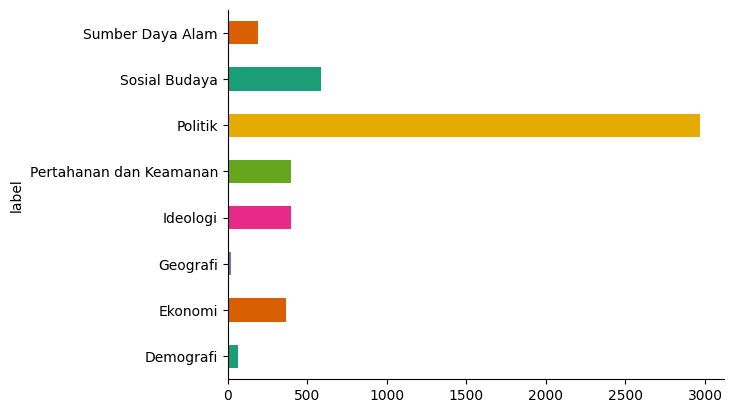

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# Check for duplicates
duplicate_count = df.duplicated().sum()
duplicate_rows = df[df.duplicated()]

In [ ]:
# Display the duplicates
print(f"Number of duplicate rows: {duplicate_count}")
print("Duplicate rows:")
print(duplicate_rows)

Number of duplicate rows: 666
Duplicate rows:
                                                c_text2  \
57    abah anies ingin mengangkat martabat petani ag...   
60    sewaktu anies bersikap kritis ke kerja pak pra...   
103   anak muda indonesia the future of this nation ...   
127   bulan januari ini serangan dari kubu dan kawan...   
142   bulan januari ini serangan dari kubu dan kawan...   
...                                                 ...   
4950  bukan cuma tampilan luarnya tapi kebijakan gan...   
4962  menjelang tengah malam ini aku mau ucapkan ter...   
4974  investorfriendly pasangan capres cawapres ganj...   
4982  bulan januari ini serangan dari kubu dan kawan...   
4985  tanggapan serius ganjar atas tindakan pengania...   

                        label  
57              Sosial Budaya  
60                    Politik  
103                  Ideologi  
127   Pertahanan dan Keamanan  
142   Pertahanan dan Keamanan  
...                       ...  
4950                 

In [ ]:
duplicate_rows.value_counts('label')

label
Sosial Budaya              180
Ideologi                   137
Pertahanan dan Keamanan    131
Ekonomi                     90
Politik                     81
Sumber Daya Alam            45
Demografi                    2
Name: count, dtype: int64

In [ ]:
# Menghapus baris yang memiliki nilai duplikat di kolom 'c_text2' dan mempertahankan yang pertama
df = df.drop_duplicates(subset=['c_text2'], keep='first')

In [ ]:
# Menampilkan DataFrame setelah menghapus duplikat
print("\nDataFrame setelah menghapus duplikat berdasarkan kolom 'c_text2':")


DataFrame setelah menghapus duplikat berdasarkan kolom 'c_text2':


In [ ]:
df.head(10)

c_text2                    label
0  kunjungan prabowo ini untuk meresmikan dan men...         Sumber Daya Alam
1  anies dapat tepuk tangan meriah saat jadi rekt...                  Politik
2  memang benar sih pendukung ada yang bodoh begi...                Demografi
3  sewaktu anies bersikap kritis ke kerja pak pra...                  Politik
4  anies baswedan harap asn termasuk tni dan polr...                  Politik
5  aduh jangan sampai pak lurah denger ini di aca...                  Politik
6  prabowo minta kemenhan dan tim satgas air unha...  Pertahanan dan Keamanan
7  anies iya allah sibukkanlah orang zalim agar d...                  Politik
8  abah itu bapa kami bapa yang berikan perhatian...                  Politik
9  bawaslu dimaki anjing sama warga gara mencopot...                  Politik

In [ ]:
# Check for duplicates
duplicate_count = df.duplicated().sum()
duplicate_rows = df[df.duplicated()]

In [ ]:
# Display the duplicates
print(f"Number of duplicate rows: {duplicate_count}")
print("Duplicate rows:")
print(duplicate_rows)

Number of duplicate rows: 0
Duplicate rows:
Empty DataFrame
Columns: [c_text2, label]
Index: []


In [ ]:
duplicate_rows.value_counts('label')

Series([], Name: count, dtype: int64)

In [ ]:
df.reset_index()

index                                            c_text2  \
0         0  kunjungan prabowo ini untuk meresmikan dan men...   
1         1  anies dapat tepuk tangan meriah saat jadi rekt...   
2         2  memang benar sih pendukung ada yang bodoh begi...   
3         3  sewaktu anies bersikap kritis ke kerja pak pra...   
4         4  anies baswedan harap asn termasuk tni dan polr...   
...     ...                                                ...   
4259   4986  melihat debat kemarin pas prabowo kicep kekira...   
4260   4987  masyarakat yakin bahwa prabowo gibran memiliki...   
4261   4988  dalam pendapat saya, keduanya tidak masuk akal...   
4262   4989  lihat itu pak ganjar anda sudah berkecimpung d...   
4263   4990  acara ini tidak hanya memasak tetapi calon pre...   

                        label  
0            Sumber Daya Alam  
1                     Politik  
2                   Demografi  
3                     Politik  
4                     Politik  
...                       ...  
4259                  Politik  
4260                  Politik  
4261                  Ekonomi  
4262  Pertahanan dan Keamanan  
4263         Sumber Daya Alam  

[4264 rows x 3 columns]



---



In [ ]:
# Menyimpan dataset ke Google Drive
df.to_csv('data_cleaned-no_stemstop.csv', index=False)

#### Kroscek Akhir

In [ ]:
df = pd.read_csv("data_cleaned-no_stemstop.csv", sep=',')

In [ ]:
df.head()

c_text2             label
0  kunjungan prabowo ini untuk meresmikan dan men...  Sumber Daya Alam
1  anies dapat tepuk tangan meriah saat jadi rekt...           Politik
2  memang benar sih pendukung ada yang bodoh begi...         Demografi
3  sewaktu anies bersikap kritis ke kerja pak pra...           Politik
4  anies baswedan harap asn termasuk tni dan polr...           Politik

In [ ]:
missing_values = df.isnull().sum()
print(missing_values)

c_text2    0
label      0
dtype: int64


In [ ]:
rows_with_missing = df[df.isnull().any(axis=1)]
print(rows_with_missing)

Empty DataFrame
Columns: [c_text2, label]
Index: []


In [ ]:
print("Jumlah duplikasi: ", df.duplicated().sum())

Jumlah duplikasi:  0


In [ ]:
# Membuat stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def preprocess_text(text):
    # Menghapus stop words
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

In [ ]:
df4 = pd.read_csv("data_cleaned-no_stemstop.csv", sep=',')

In [ ]:
df4['stop_free'] = df4['c_text2'].apply(preprocess_text)

In [ ]:
# Menyimpan dataset ke Google Drive
df4.to_csv('data_cleaned-no_stop.csv', index=False)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Combine all text data into one large string
all_text = ' '.join(df4['c_text2'])

# Use CountVectorizer to tokenize and collect unique words
vectorizer = CountVectorizer()
vectorizer.fit_transform([all_text])
vocabulary = vectorizer.get_feature_names_out()

In [ ]:
# Save the vocabulary to a file
vocab_file_path = 'vocabulary.txt'
with open(vocab_file_path, 'w') as f:
    for word in vocabulary:
        f.write(f"{word}\n")

print("Vocabulary collected and saved.")

Vocabulary collected and saved.




---



### **UNTUK STEMMING dan STOPWORDS**

 membuang kata yang tidak penting

In [ ]:
stop_words = set([
    "ada", "adalah", "adanya", "adapun", "agak", "agaknya", "agar", "akan", "akankah", "akhir",
    "akhiri", "akhirnya", "aku", "akulah", "amat", "amatlah", "anda", "andalah", "antar",
    "antara", "antaranya", "apa", "apaan", "apabila", "apakah", "apalagi", "apatah", "artinya",
    "asal", "asalkan", "atas", "atau", "ataukah", "ataupun", "awal", "awalnya", "bagai",
    "bagaikan", "bagaimana", "bagaimanakah", "bagaimanapun", "bagi", "bagian", "bahkan",
    "bahwa", "bahwasanya", "baik", "bakal", "bakalan", "balik", "banyak", "bapak", "baru",
    "bawah", "beberapa", "begini", "beginian", "beginikah", "beginilah", "begitu", "begitukah",
    "begitulah", "begitupun", "bekerja", "belakang", "belakangan", "belum", "belumlah", "benar",
    "benarkah", "benarlah", "berada", "berakhir", "berakhirlah", "berakhirnya", "berapa",
    "berapakah", "berapalah", "berapapun", "berarti", "berawal", "berbagai", "berdatangan",
    "beri", "berikan", "berikut", "berikutnya", "berjumlah", "berkali-kali", "berkata",
    "berkehendak", "berkeinginan", "berkenaan", "berlainan", "berlalu", "berlangsung",
    "berlebihan", "bermacam", "bermacam-macam", "bermaksud", "bermula", "bersama", "bersama-sama",
    "bersiap", "bersiap-siap", "bertanya", "bertanya-tanya", "berturut", "berturut-turut",
    "bertutur", "berujar", "berupa", "besar", "betul", "betulkah", "biasa", "biasanya", "bila",
    "bilakah", "bisa", "bisakah", "boleh", "bolehkah", "bolehlah", "buat", "bukan", "bukankah",
    "bukanlah", "bukannya", "bulan", "bung", "cara", "caranya", "cukup", "cukupkah", "cukuplah",
    "cuma", "dahulu", "dalam", "dan", "dapat", "dari", "daripada", "datang", "dekat", "demi",
    "demikian", "demikianlah", "dengan", "depan", "di", "dia", "diakhiri", "diakhirinya",
    "dialah", "diantara", "diantaranya", "diberi", "diberikan", "diberikannya", "dibuat",
    "dibuatnya", "didapat", "didatangkan", "digunakan", "diibaratkan", "diibaratkannya",
    "diingat", "diingatkan", "diinginkan", "dijawab", "dijelaskan", "dijelaskannya", "dikarenakan",
    "dikatakan", "dikatakannya", "dikerjakan", "diketahui", "diketahuinya", "dikira", "dilakukan",
    "dilalui", "dilihat", "dimaksud", "dimaksudkan", "dimaksudkannya", "dimaksudnya", "diminta",
    "dimintai", "dimisalkan", "dimulai", "dimulailah", "dimulainya", "dimungkinkan", "dini",
    "dipastikan", "diperbuat", "diperbuatnya", "dipergunakan", "diperkirakan", "diperlihatkan",
    "diperlukan", "diperlukannya", "dipersoalkan", "dipertanyakan", "dipunyai", "diri", "dirinya",
    "disampaikan", "disebut", "disebutkan", "disebutkannya", "disini", "disinilah", "ditambahkan",
    "ditandaskan", "ditanya", "ditanyai", "ditanyakan", "ditegaskan", "ditujukan", "ditunjuk",
    "ditunjuki", "ditunjukkan", "ditunjukkannya", "ditunjuknya", "dituturkan", "dituturkannya",
    "diucapkan", "diucapkannya", "diungkapkan", "dong", "dua", "dulu", "empat", "enggak",
    "enggaknya", "entah", "entahlah", "guna", "gunakan", "hal", "hampir", "hanya", "hanyalah",
    "hari", "harus", "haruslah", "harusnya", "hendak", "hendaklah", "hendaknya", "hingga", "ia",
    "ialah", "ibarat", "ibaratkan", "ibaratnya", "ibu", "ikut", "ingat", "ingat-ingat", "ingin",
    "inginkah", "inginkan", "ini", "inikah", "inilah", "itu", "itukah", "itulah", "jadi", "jadilah",
    "jadinya", "jangan", "jangankan", "janganlah", "jauh", "jawab", "jawaban", "jawabnya", "jelas",
    "jelaskan", "jelaslah", "jelasnya", "jika", "jikalau", "juga", "jumlah", "jumlahnya", "justru",
    "kala", "kalau", "kalaulah", "kalaupun", "kalian", "kami", "kamilah", "kamu", "kamulah", "kan",
    "kapan", "kapankah", "kapanpun", "karena", "karenanya", "kasus", "kata", "katakan", "katakanlah",
    "katanya", "ke", "keadaan", "kebetulan", "kecil", "kedua", "keduanya", "keinginan", "kelamaan",
    "kelihatan", "kelihatannya", "kelima", "keluar", "kembali", "kemudian", "kemungkinan",
    "kemungkinannya", "kenapa", "kepada", "kepadanya", "kesampaian", "keseluruhan", "keseluruhannya",
    "keterlaluan", "ketika", "khususnya", "kini", "kinilah", "kira", "kira-kira", "kiranya", "kita",
    "kitalah", "kok", "kurang", "lagi", "lagian", "lah", "lain", "lainnya", "lalu", "lama", "lamanya",
    "lanjut", "lanjutnya", "lebih", "lewat", "lima", "luar", "macam", "maka", "makanya", "makin",
    "malah", "malahan", "mampu", "mampukah", "mana", "manakala", "manalagi", "masa", "masalah",
    "masalahnya", "masih", "masihkah", "masing", "masing-masing", "mau", "maupun", "melainkan",
    "melakukan", "melalui", "melihat", "melihatnya", "memang", "memastikan", "memberi", "memberikan",
    "membuat", "memerlukan", "memihak", "meminta", "memintakan", "memisalkan", "memperbuat",
    "mempergunakan", "memperkirakan", "memperlihatkan", "mempersiapkan", "mempersoalkan",
    "mempertanyakan", "mempunyai", "memulai", "memungkinkan", "menaiki", "menambahkan", "menandaskan",
    "menanti", "menanti-nanti", "menantikan", "menanya", "menanyai", "menanyakan", "mendapat",
    "mendapatkan", "mendatang", "mendatangi", "mendatangkan", "menegaskan", "mengakhiri", "mengapa",
    "mengatakan", "mengatakannya", "mengenai", "mengerjakan", "mengetahui", "menggunakan",
    "menghendaki", "mengibaratkan", "mengibaratkannya", "mengingat", "mengingatkan", "menginginkan",
    "mengira", "mengucapkan", "mengucapkannya", "mengungkapkan", "menjadi", "menjawab", "menjelaskan",
    "menuju", "menunjuk", "menunjuki", "menunjukkan", "menunjuknya", "menurut", "menuturkan",
    "menyampaikan", "menyangkut", "menyatakan", "menyebutkan", "menyeluruh", "menyiapkan", "merasa",
    "mereka", "merekalah", "merupakan", "meski", "meskipun", "meyakini", "meyakinkan", "minta",
    "mirip", "misal", "misalkan", "misalnya", "mula", "mulai", "mulailah", "mulanya", "mungkin",
    "mungkinkah", "nah", "naik", "namun", "nanti", "nantinya", "nyaris", "nyatanya", "oleh",
    "olehnya", "pada", "padahal", "padanya", "pak", "paling", "panjang", "pantas", "para", "pasti",
    "pastilah", "penting", "pentingnya", "per", "percuma", "perlu", "perlukah", "perlunya", "pernah",
    "persoalan", "pertama", "pertama-tama", "pertanyaan", "pertanyakan", "pihak", "pihaknya", "pukul",
    "pula", "pun", "punya", "rasa", "rasanya", "rata", "rupanya", "saat", "saatnya", "saja", "sajalah",
    "saling", "sama", "sama-sama", "sambil", "sampai", "sampai-sampai", "sampaikan", "sana", "sangat",
    "sangatlah", "satu", "saya", "sayalah", "se", "sebab", "sebabnya", "sebagai", "sebagaimana",
    "sebagainya", "sebagian", "sebaik", "sebaik-baiknya", "sebaiknya", "sebaliknya", "sebanyak",
    "sebegini", "sebegitu", "sebelum", "sebelumnya", "sebenarnya", "seberapa", "sebesar", "sebetulnya",
    "sebisanya", "sebuah", "sebut", "sebutlah", "sebutnya", "secara", "secukupnya", "sedang",
    "sedangkan", "sedemikian", "sedikit", "sedikitnya", "seenaknya", "segala", "segalanya", "segera",
    "seharusnya", "sehingga", "seingat", "sejak", "sejauh", "sejenak", "sejumlah", "sekadar",
    "sekadarnya", "sekali", "sekali-kali", "sekalian", "sekaligus", "sekalipun", "sekarang", "sekecil",
    "seketika", "sekiranya", "sekitar", "sekitarnya", "sekurang-kurangnya", "sekurangnya", "sela",
    "selagi", "selain", "selaku", "selalu", "selama", "selama-lamanya", "selamanya", "selanjutnya",
    "seluruh", "seluruhnya", "semacam", "semakin", "semampu", "semampunya", "semasa", "semasih",
    "semata", "semata-mata", "semaunya", "sementara", "semisal", "semisalnya", "sempat", "semua",
    "semuanya", "semula", "sendiri", "sendirian", "sendirinya", "seolah", "seolah-olah", "seorang",
    "sepanjang", "sepantasnya", "sepantasnyalah", "seperlunya", "seperti", "sepertinya", "sepihak",
    "sering", "seringnya", "serta", "serupa", "sesaat", "sesama", "sesampai", "sesegera", "sesekali",
    "seseorang", "sesuatu", "sesuatunya", "sesudah", "sesudahnya", "setelah", "setempat", "setengah",
    "seterusnya", "setiap", "setiba", "setibanya", "setidak-tidaknya", "setidaknya", "setinggi",
    "seusai", "sewaktu", "siap", "siapa", "siapakah", "siapapun", "sini", "sinilah", "soal", "soalnya",
    "suatu", "sudah", "sudahkah", "sudahlah", "supaya", "tadi", "tadinya", "tahu", "tahun", "tak",
    "tambah", "tambahnya", "tampak", "tampaknya", "tandas", "tandasnya", "tanpa", "tanya", "tanyakan",
    "tanyanya", "tapi", "tegas", "tegasnya", "telah", "tempat", "tengah", "tentang", "tentu",
    "tentulah", "tentunya", "tepat", "terakhir", "terasa", "terbanyak", "terdahulu", "terdapat",
    "terdiri", "terhadap", "terhadapnya", "teringat", "teringat-ingat", "terjadi", "terjadilah",
    "terjadinya", "terkira", "terlalu", "terlebih", "terlihat", "termasuk", "ternyata", "tersampaikan",
    "tersebut", "tersebutlah", "tertentu", "tertuju", "terus", "terutama", "tetap", "tetapi", "tiap",
    "tiba", "tiba-tiba", "tidak", "tidakkah", "tidaklah", "tiga", "tinggi", "toh", "tunjuk", "turut",
    "tutur", "tuturnya", "ucap", "ucapnya", "ujar", "ujarnya", "umum", "umumnya", "ungkap", "ungkapnya",
    "untuk", "usah", "usai", "waduh", "wah", "wahai", "waktu", "waktunya", "walau", "walaupun",
    "wong", "yaitu", "yakin", "yakni", "yang"
])

In [ ]:
# Membuat stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def preprocess_text(text):
    # Menghapus stop words
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    # Melakukan stemming
    text = stemmer.stem(text)
    return text

In [ ]:
df3 = df[['c_text2', 'label']]

In [ ]:
df3['stem_stop'] = df3['c_text2'].apply(preprocess_text)

In [ ]:
# Menyimpan dataset ke Google Drive
df3.to_csv('data_cleaned-with_stemstop.csv', index=False)

#Exploratory Data Analysis (EDA)


In [ ]:
df = pd.read_csv("data_cleaned-no_stemstop.csv", sep=',')

distribusi setiap kategori
buat wordcloud -> kira kira kata apa saja disetiap kategori, penggunaan kosakata kategori

In [ ]:
df.describe(include="all")

c_text2    label
count                                                4264     4264
unique                                               4264        8
top     acara ini tidak hanya memasak tetapi calon pre...  Politik
freq                                                    1     2867

##distribusi data

In [ ]:
value_counts = df['label'].value_counts().reset_index()
value_counts.columns = ['label', 'frequency']

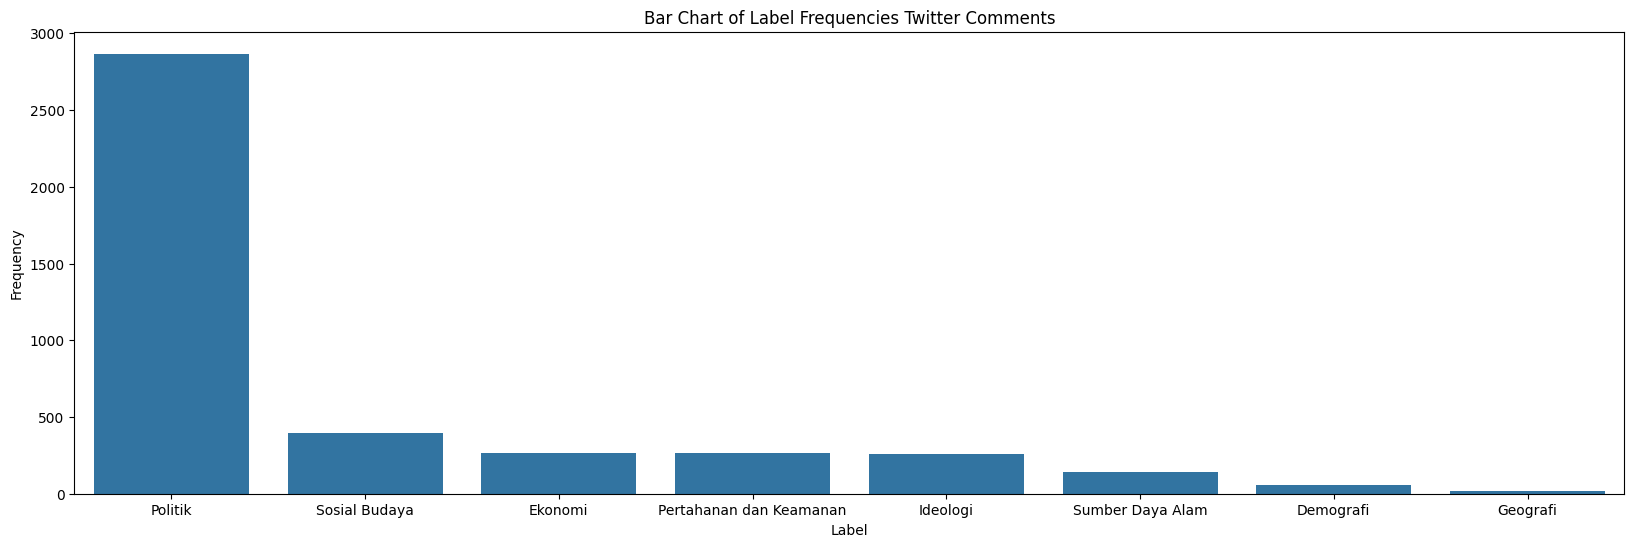

In [ ]:
plt.figure(figsize=(20, 6))
sns.barplot(x='label', y='frequency', data=value_counts)
plt.title('Bar Chart of Label Frequencies Twitter Comments')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.value_counts('label')

label
Politik                    2867
Sosial Budaya               394
Ekonomi                     267
Pertahanan dan Keamanan     264
Ideologi                    257
Sumber Daya Alam            139
Demografi                    57
Geografi                     19
Name: count, dtype: int64

##wordcloud class (class paling sering muncul)

In [ ]:
freq_dict = value_counts.set_index('label').to_dict()['frequency']

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

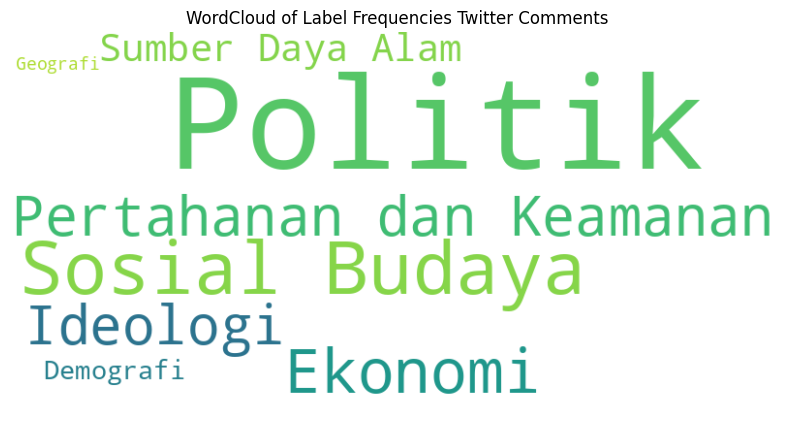

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Label Frequencies Twitter Comments')
plt.show()

##wordcloud comment (kata dalam comment yang paling sering muncul)

In [ ]:
all_comments = ' '.join(df['c_text2'])

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_comments)

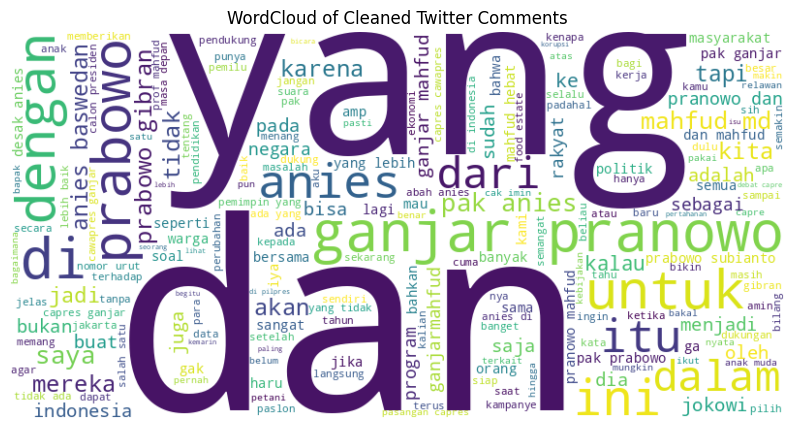

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Cleaned Twitter Comments')
plt.show()

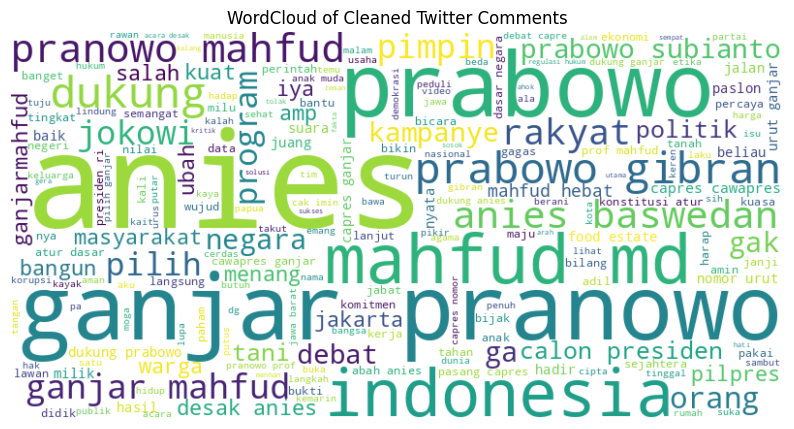

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Cleaned Twitter Comments')
plt.show()

##wordcloud comment per kategori

In [ ]:
def create_wordcloud_for_category(category, dataset):
    category_data = dataset[dataset['label'] == category]
    all_cleaned_comments = ' '.join(category_data['cleaned_text_2'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_cleaned_comments)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {category.capitalize()} Comments')
    plt.show()

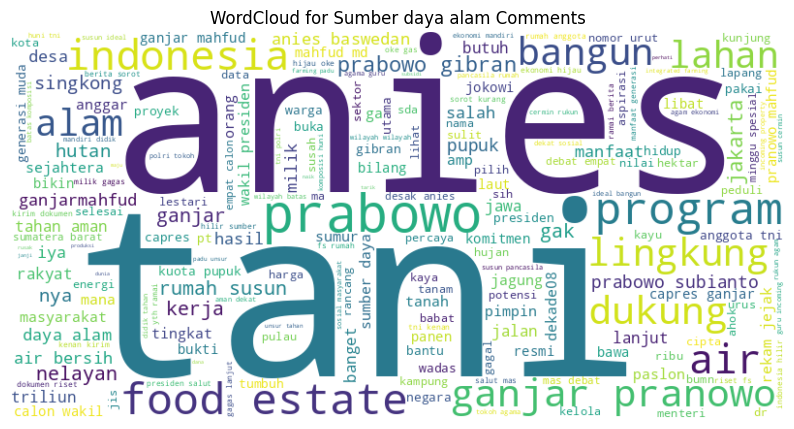

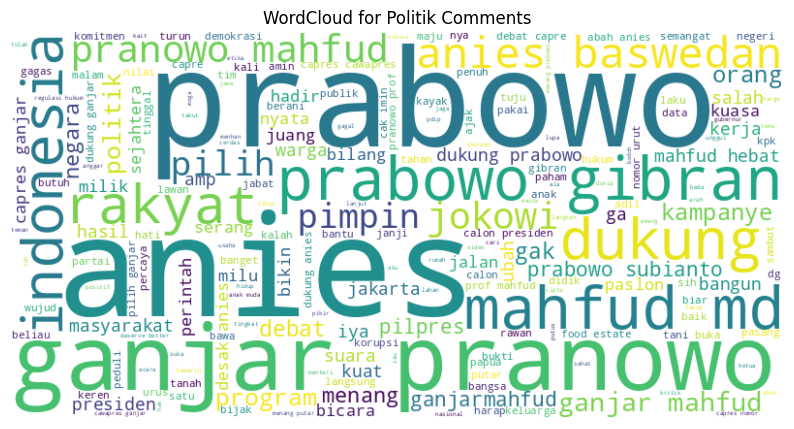

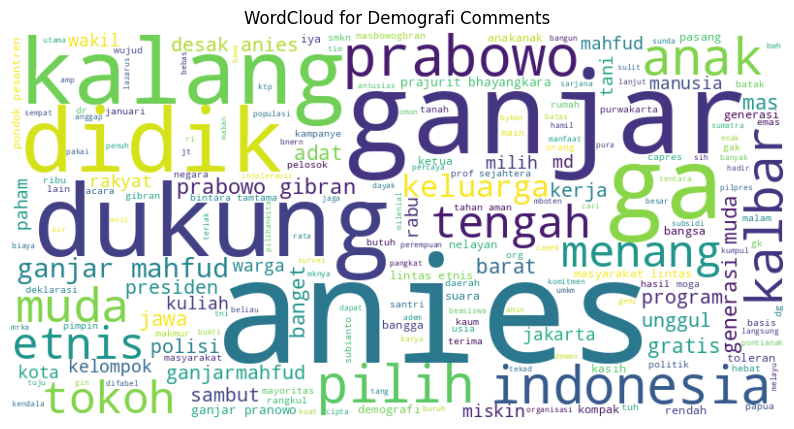

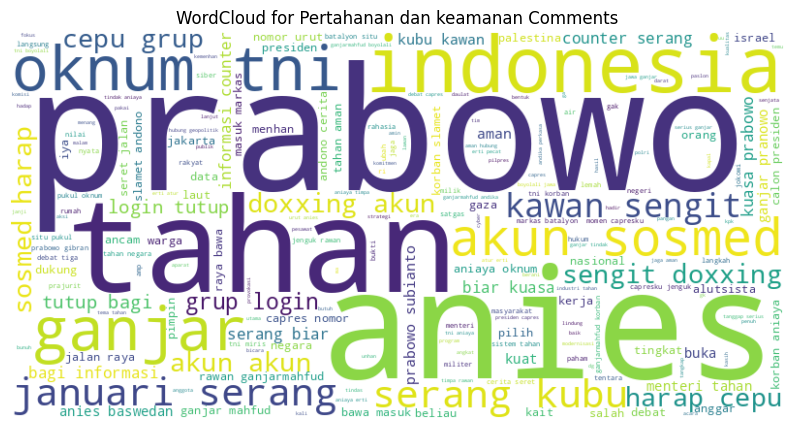

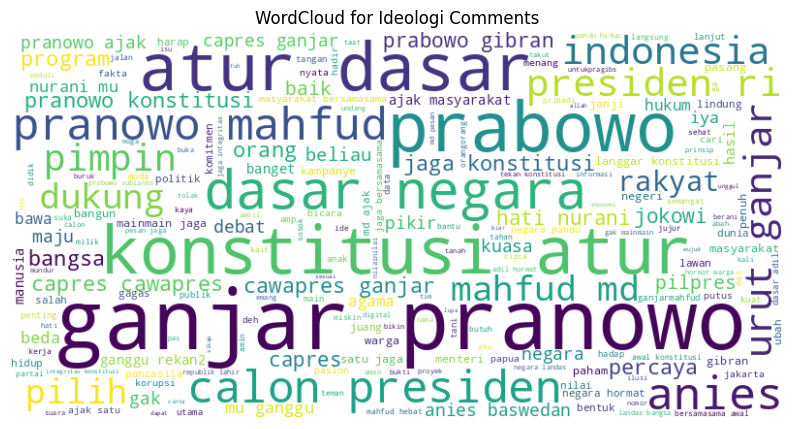

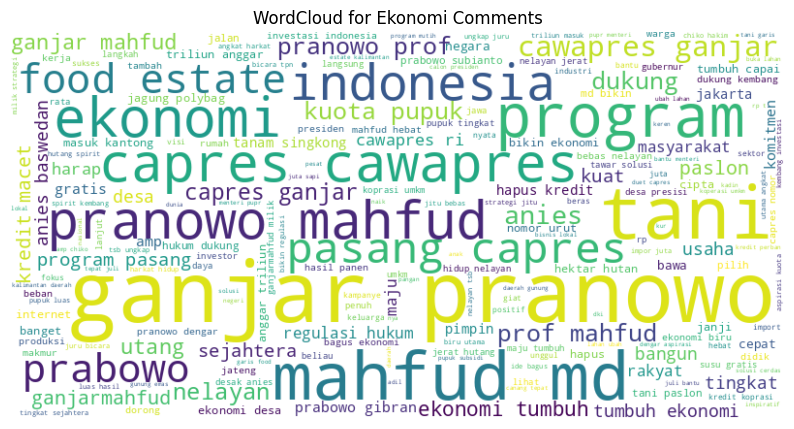

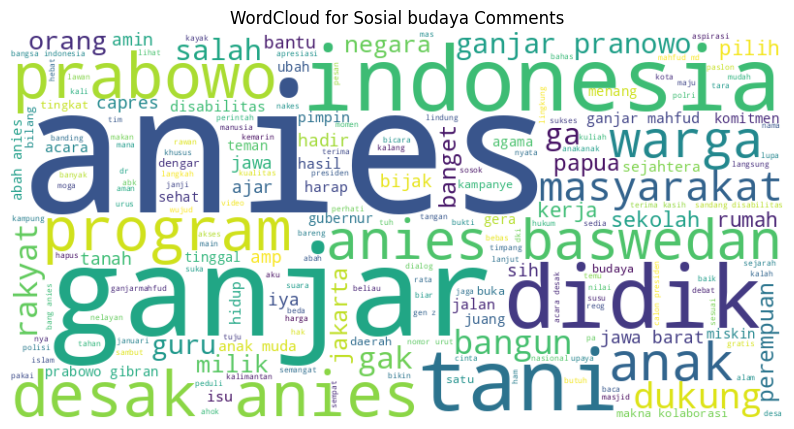

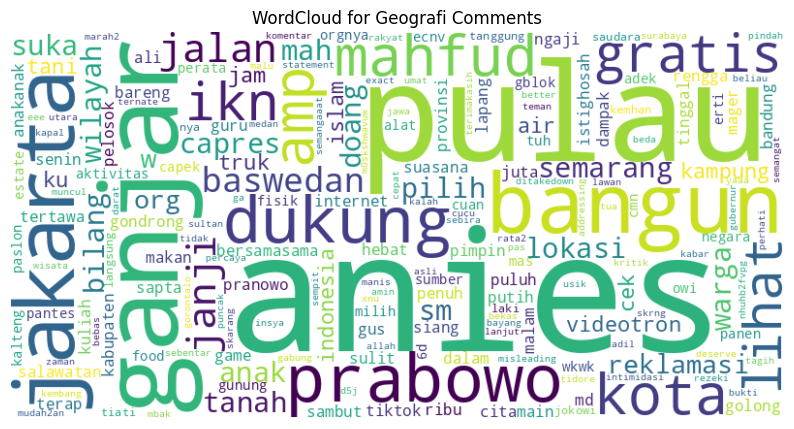

In [ ]:
categories = cleaned_df['label'].unique()
for category in categories:
    create_wordcloud_for_category(category, cleaned_df)

# Model Selection

In [ ]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torchvision

model_ckpt = "indobenchmark/indobert-large-p1"
tokenizer = BertTokenizer.from_pretrained(model_ckpt)

model = BertForSequenceClassification.from_pretrained(model_ckpt, num_labels=8)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    B_Acc = balanced_accuracy_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "Balanced Accuracy": B_Acc}

##Label Encoder for Classification

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded= label_encoder.fit_transform(df['label'])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label to index mapping:", label_mapping)

Label to index mapping: {'Demografi': 0, 'Ekonomi': 1, 'Geografi': 2, 'Ideologi': 3, 'Pertahanan dan Keamanan': 4, 'Politik': 5, 'Sosial Budaya': 6, 'Sumber Daya Alam': 7}


##Split Data and Tokenize

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df['c_text2'].astype(str).tolist(), y_encoded, test_size=0.3, random_state=0)

In [ ]:
def tokenize(batch):
    return tokenizer(batch, padding='max_length', truncation=True, max_length=80, return_tensors='pt')

In [ ]:
# Tokenizing the data
train_encodings = tokenize(X_train)
test_encodings = tokenize(X_test)

In [ ]:
train_encodings

{'input_ids': tensor([[    2, 15800,   556,  ...,     0,     0,     0],
        [    2,  2038, 14785,  ...,     0,     0,     0],
        [    2, 19145,   500,  ...,     0,     0,     0],
        ...,
        [    2, 21250,  3526,  ...,     0,     0,     0],
        [    2,    79,  9768,  ...,     0,     0,     0],
        [    2,   640,  5267,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self,encodings,labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self,idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels']=torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = Dataset(train_encodings, y_train)
test_dataset = Dataset(test_encodings, y_test)

In [ ]:
from transformers import Trainer, TrainingArguments
batch_size = 24

logging_steps = len(train_dataset) // batch_size

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    learning_rate = 1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps = 500,
    evaluation_strategy ="epoch",
    weight_decay=0.01,
    disable_tqdm=False,
    logging_dir='./logs',
    logging_steps=logging_steps,
    log_level="error"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= train_dataset,
    eval_dataset = test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

<ipython-input-28-aece94a7f594>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


<ipython-input-28-aece94a7f594>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-28-aece94a7f594>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-28-aece94a7f594>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-28-aece94a7f594>:7: UserWarning: To copy construct from a 

TrainOutput(global_step=1250, training_loss=0.12069741008281708, metrics={'train_runtime': 390.5251, 'train_samples_per_second': 76.41, 'train_steps_per_second': 3.201, 'total_flos': 4345218069196800.0, 'train_loss': 0.12069741008281708, 'epoch': 10.0})

In [ ]:
preds_output = trainer.predict(test_dataset)

<ipython-input-28-aece94a7f594>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
preds_output.metrics

{'test_loss': 1.759015440940857,
 'test_accuracy': 0.73046875,
 'test_Balanced Accuracy': 0.38231147221861056,
 'test_runtime': 4.5029,
 'test_samples_per_second': 284.26,
 'test_steps_per_second': 11.992}

# indoBERT

In [ ]:
model_ckpt = "indolem/indobert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_ckpt)

model = BertForSequenceClassification.from_pretrained(model_ckpt, num_labels=8)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/234k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    B_Acc = balanced_accuracy_score(labels, preds)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "Balanced Accuracy": B_Acc}

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded= label_encoder.fit_transform(df['label'])

In [ ]:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label to index mapping:", label_mapping)

Label to index mapping: {'Demografi': 0, 'Ekonomi': 1, 'Geografi': 2, 'Ideologi': 3, 'Pertahanan dan Keamanan': 4, 'Politik': 5, 'Sosial Budaya': 6, 'Sumber Daya Alam': 7}


In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df['c_text2'].astype(str).tolist(), y_encoded, test_size=0.3, random_state=0)

In [ ]:
def tokenize(batch):
    return tokenizer(batch, padding='max_length', truncation=True, max_length=80, return_tensors='pt')

In [ ]:
# Tokenizing the data
train_encodings = tokenize(X_train)
test_encodings = tokenize(X_test)

In [ ]:
train_encodings

{'input_ids': tensor([[    3, 14979,  2458,  ...,     0,     0,     0],
        [    3,  3776, 26447,  ...,     0,     0,     0],
        [    3, 16169,  1520,  ...,     0,     0,     0],
        ...,
        [    3,  1975,  1476,  ...,     0,     0,     0],
        [    3,  1545,  7558,  ...,     0,     0,     0],
        [    3,  1962,  7595,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self,encodings,labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self,idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels']=torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

train_dataset = Dataset(train_encodings, y_train)
test_dataset = Dataset(test_encodings, y_test)

In [ ]:
from transformers import Trainer, TrainingArguments
batch_size = 24

logging_steps = len(train_dataset) // batch_size

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    learning_rate = 1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps = 500,
    evaluation_strategy ="epoch",
    weight_decay=0.01,
    disable_tqdm=False,
    logging_dir='./logs',
    logging_steps=logging_steps,
    log_level="error"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= train_dataset,
    eval_dataset = test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

<ipython-input-44-aece94a7f594>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


<ipython-input-44-aece94a7f594>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-44-aece94a7f594>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-44-aece94a7f594>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-44-aece94a7f594>:7: UserWarning: To copy construct from a 

TrainOutput(global_step=1250, training_loss=0.8510887924194336, metrics={'train_runtime': 134.1381, 'train_samples_per_second': 222.457, 'train_steps_per_second': 9.319, 'total_flos': 1226821382860800.0, 'train_loss': 0.8510887924194336, 'epoch': 10.0})

In [ ]:
preds_output = trainer.predict(test_dataset)

<ipython-input-28-aece94a7f594>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
preds_output.metrics

{'test_loss': 1.759015440940857,
 'test_accuracy': 0.73046875,
 'test_Balanced Accuracy': 0.38231147221861056,
 'test_runtime': 4.5029,
 'test_samples_per_second': 284.26,
 'test_steps_per_second': 11.992}